In [1]:
import pickle
import scipy.stats
import matplotlib.pyplot as plt
from hdf5storage import loadmat

import torch
import torch.nn as nn

import pyro
import pyro.optim
import pyro.infer
import pyro.distributions as dist

from util import *
from model import kalman_filter, inference

pyro.enable_validation(True)

# Neural dynamics of speech processing

### Menoua Keshishian (mk4011@columbia.edu)

<br/>

## Introduction

The goal of this project is to study the neural dynamics of speech processing in different parts of the human cortex. When the mechanical wave that is sound reaches the ear, it is first transformed into an electric signal in the cochlea. This transformation is basically a biological implementation of a Fourier transform with a logarithmic frequency scale. This electric signal is then passed to the brain through the auditory nerve for further processing. The initial processing of the sound in the cortex is carried out in different areas comprising the primary auditory cortex. The signal is then passed to higher levels of the auditory cortex for further processing and is eventually integrated into the bigger cortical representation. (Figure 1)

<figure>
    <center>
    <img src="https://2e.mindsmachine.com/figures/06/lowres/MM2e-Fig-06-06-0.jpg" width=400 height=400>
    <figcaption><em>Figure 1. The human auditory pathway</em></figcaption>
    </center>
</figure>

We will be modeling the biological neural network that exists between the cochlea and different regions of the cortex. In other words, our model should predict the neural activity in a neural site given the frequency representation of the auditory stimulus. Here, we define neural activity as the envelope of the high-gamma (70-150Hz) band-passed signal recorded at that location. Previous research has demonstrated that the envelope of the high-gamma is a rough representative of the firing rate of the nearby neural population, which is the reason behind our choice.

In theory, a neuron acts as a Kalman filter with external inputs (Figure 2). It receives an external signal (input current from other neurons) which drives its internal dynamic state (membrane voltage), and that internal state gives rise to outputs (action potentials). We can generalize this to a population of hundreds or thousands of neighboring neurons, assuming that neurons in this group are performing a similar task, which is usually the case for neighboring neurons. Now assume in this big population we have $N$ distinct underlying networks of neurons that act separately from each other. In this case, the input would be the firing rate of external neurons projecting into this group, the $N$ internal states would be the firing rate of each of the underlying subgroups, and the output would be the electrical measurement performed at an electrode location which can be approximated as a linear combination of the activity of the underlying subgroups plus an additive gaussian noise.

<figure>
    <center>
    <img src="model.png" width=450 height=450>
    <figcaption><em>Figure 2. A neuron modeled as a Kalman filter with external inputs</em></figcaption>
    </center>
</figure>

## Data

We played approximately thirty minutes of natural speech to human subjects while recording their neural activity. All subjects were diagnosed with pharmacoresistant epilepsy and were being monitored for seizures using intracranial electrocorticography (ECoG). Our data is aggregated across five subjects covering different regions of the auditory cortex. We selected three of those regions with sufficient coverage to study:
1. Heschl's gyrus (HG), primary -- 65 electrodes
2. Planum temporale (PT), nonprimary -- 25 electrodes
3. Superior temporal gyrus (STG), nonprimary -- 76 electrodes

Data consists of 8 sequences totalling 40.0 seconds.

5 seconds of sample stimulus of speech:


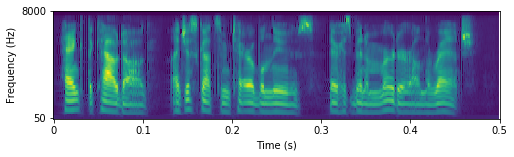

5 seconds of sample response to speech:


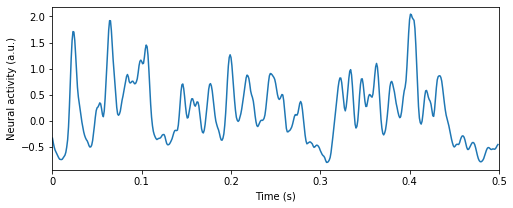

Sample windowed input (10 time steps * (20, 10) frequency bins):


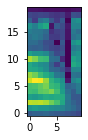

electrodes: 166 (HG: 65, PT: {ind_pt.sum()}, STG: {ind_stg.sum()})


In [2]:
mdata = loadmat("data_test.mat")
stim_vl, data_vl, locz = mdata["stim_vl"], mdata["data_vl"], mdata["loc"]
del mdata

# Displaay summary of input and output
summary_data(stim_vl, data_vl)

# Prepare input and output variables for model
window, downsample = 10, 3
U, Z = prep_variables(stim_vl, data_vl, window=window, downsample=downsample, show_sample=True)

# Select specific regions
Z, ind_hg, ind_pt, ind_stg = filter_electrodes(Z, locz)

num_sequences = len(U)
udim, zdim = U[0].shape[-1], Z[0].shape[-1]

## Model

We make some assumptions in our model for simplicity:
* All measurements are made from the same set of latent variables, i.e. one universal model
* The input to the model comes directly from the cochlea, i.e. no explicit between region communication
* There are no nonlinearities in the model (biological neurons are famous with their nonlinearities)
* Gaussian noise with fixed variance on states and measurements
* All elements of the parameters are independent from each other

Model parameters that we do inference on:
1. $\operatorname{F_{diag}}$: Diagonal elements of state transition matrix
2. $\operatorname{F_{rest}}$: Non-diagonal elements of state transition matrix
3. $\operatorname{G}$: Input-state transition matrix
4. $\operatorname{H}$: State-measurement transition matrix
3. $\operatorname{b}$: Measurement bias matrix

In [3]:
xdim = 1 # Number of latent states
model, guide = kalman_filter(udim, xdim, zdim, cuda=False, jit=False)

## Priors

We make some assumptions on the priors for stability:
* State transition is positive and less than one on the diagonal (prevents alternating sign and exploding state)
* Measurement operator is nonnegative

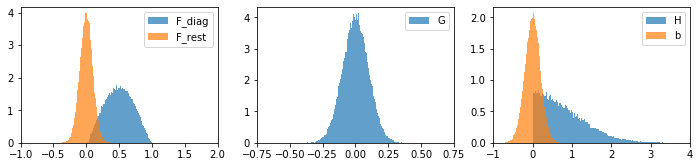

In [2]:
summary_prior()

## Inference

For inference, we do MAP estimation using stochastic variational inference ($\operatorname{SVI}$) with $\operatorname{AutoDelta}$ for guide, $\operatorname{ELBO}$ for loss, and $\operatorname{Adam}$ as the optimizer. We run the optimizer for 100 iterations on the full training data which consists of 54 sequences of varying lengths totalling 30 minutes. The sequences are batched so that the data has shape $[N\times T\times C]$, where $N$ is the number of sequences, $T$ is the length of the longest sequence, and $C$ is the number of data dimensions (i.e. 200 for input, number of electrodes for output).

In [4]:
optim = pyro.optim.Adam({'lr': 1e-3})
svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO())

history = inference(svi, U, Z)

2019/11/20-04:06 -- [iteration 0001] loss: 3.6442 -- epoch time: 0.796 sec
2019/11/20-04:06 -- [iteration 0011] loss: 3.2335 -- epoch time: 0.538 sec
2019/11/20-04:06 -- [iteration 0021] loss: 3.0590 -- epoch time: 0.519 sec
2019/11/20-04:06 -- [iteration 0031] loss: 2.9109 -- epoch time: 0.537 sec
2019/11/20-04:06 -- [iteration 0041] loss: 2.8356 -- epoch time: 0.559 sec
2019/11/20-04:07 -- [iteration 0051] loss: 2.7951 -- epoch time: 0.550 sec
2019/11/20-04:07 -- [iteration 0061] loss: 2.6580 -- epoch time: 0.547 sec
2019/11/20-04:07 -- [iteration 0071] loss: 2.6469 -- epoch time: 0.555 sec
2019/11/20-04:07 -- [iteration 0081] loss: 2.5995 -- epoch time: 0.552 sec
2019/11/20-04:07 -- [iteration 0091] loss: 2.5367 -- epoch time: 0.511 sec


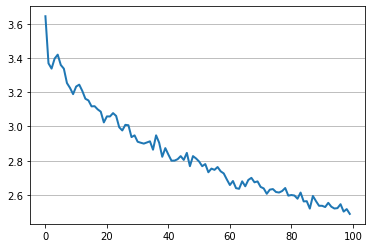

In [6]:
plt.plot(history, linewidth=2)
plt.grid(axis='y')
plt.show()

In [ ]:
params = pyro.get_param_store()
F, G, H, b = read_params(params, xdim, zdim)

### Load precomputed MAP estimates

The actual inference is run on the training dataset (~30 minutes of speech) which takes several hours, but the inference results are saved in separate files so that we can use them to perform predictions on the test dataset (40 seconds) in the next section.

In [5]:
xdim = 3

params = pickle.load(open(f"models/kalman_x{xdim}.pkl", "rb"))
F, G, H, b = read_params(params, xdim, zdim)

We first check out the state transition matrix $\operatorname{F}$:

In [6]:
F

tensor([[ 0.4961, -0.0520, -0.0559],
        [-0.0882,  0.4259, -0.0932],
        [-0.0525, -0.0610,  0.3743]])

Next, we look at the input-state transition matrix $\operatorname{G}$.

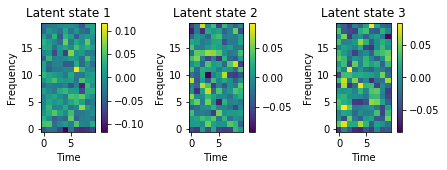

In [7]:
summary_G(G, window)

As we can see the input $\operatorname{G}$ matrices are very noisy. To get a better look at them we smooth each one out with a $3\times3$ gaussian kernel.

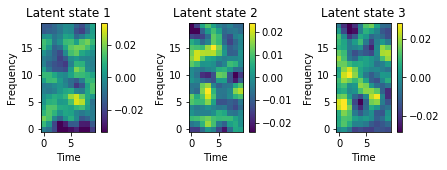

In [8]:
summary_G(G, window, smooth=True)

Finally, we examine the state-measurement matrix $\operatorname{H}$ and the measurement bias vector $\operatorname{b}$:

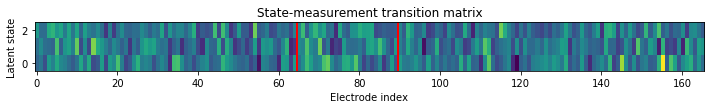

In [9]:
summary_H(H)

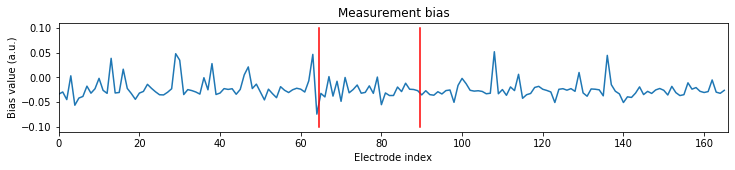

In [10]:
summary_b(b)

## Criticism

For criticism, we use the estimated parameters to predict the output at each neural site, then calculate the pearson correlation between the prediction and the measurement.

### Predict latent states and measurements

In [18]:
x, z = [], []
for i in range(len(U)):
    x.append([])
    z.append([])
    
    x0 = torch.zeros(xdim)
    for t in range(len(U[i])):
        x[i] += [G @ U[i][t] + F @ (x0 if t==0 else x[i][t-1])]
        z[i] += [H @ x[i][t]]
    x[i], z[i] = torch.stack(x[i]), torch.stack(z[i])
x, z = torch.stack(x), torch.stack(z)
x.shape, z.shape

(torch.Size([8, 500, 3]), torch.Size([8, 500, 166]))

### Assess prediction accuracy

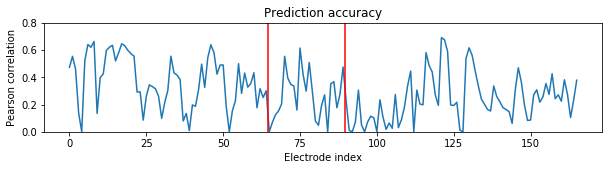

tensor(0.2991)


In [19]:
Q = torch.zeros(num_sequences, zdim)
for i in range(num_sequences):
    for j in range(zdim):
        Q[i,j] = scipy.stats.pearsonr(z[i][:,j], Z[i][:,j])[0]
Q = torch.mean(Q, dim=0)
Q = torch.clamp_min(Q, 0)

summary_accuracy(Q)

# print(Q)
print(Q.mean())

## Some observations

The following are some interesting observations from the inference results:
* The average prediction accuracy across all electrodes is almost the same when using 1, 2, or 3 latent states.

* In the cases of 2 and 3 latent state variables, the non-diagonal elements of the state transition matrix were all negative, possibly hinting at a sparse representation, i.e. when one state is active the other are inhibited. The relation between different states should be further studied in detail.

* Using the smoothed $\operatorname{G}$ matrix for making new predictions resulted in slightly but robustly higher accuracy (about 1% increase). This is expected, as the neighboring elements of the matrix correspond to neighboring times or frequencies in the stimulus, which are highly correlated.

* A simple way to study what each latent state represents is to observe the weights given to each state for electrodes in different regions. Ideally, some states would be more relevant to some specific regions. In our data however, we see no significant difference between them. All three regions use all states almost equally.

* Finally, observing the dynamics of the latent states can be very interesting. The time courses of three latent states is plotted below for the first 5 second sequence of the test data set. Note that the states are mostly positive, which means they will not be cancelling each other out which is good. Each state can be studied in detail to determine its responsive properties. So far, there was no structure apparent between the latent states.

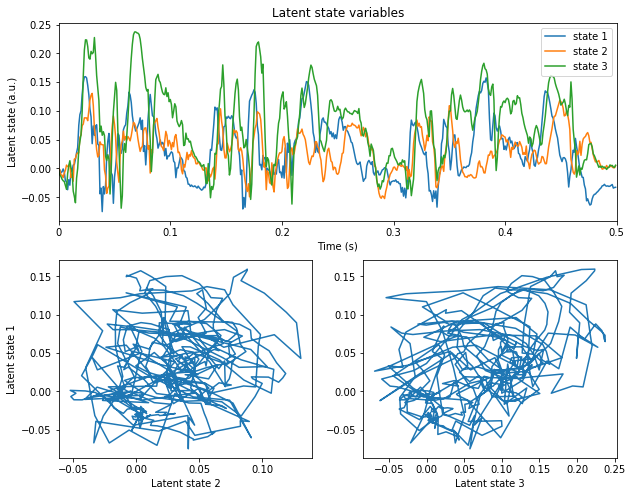

In [20]:
summary_state(x[0])

## Problems faced

Here are some of the problems that came up in this project:
1. It took a long time to get the inference working for the dynamical model
2. If the state transition matrix is not properly constrained the inference will soon run into **nan** territory
3. Using $\operatorname{AutoDiagonalNormal}$ as guide did not converge for latent state dimension of 1 and failed for dimensions of 2 and 3.
4. A latent state dimension of 32 resulted in a significant drop in prediction performance in both train and test sets. This is very interesting but as of now the reason behind it remains unclear.

## Summary

This project was aimed at gaining insight into the neural dynamics of speech processing. We defined a kalman filter with a maximum of 3 latent states and performed MAP estimation with SVI. The resulting models could predict the neural data reasonably but there are still some issues to iron out. More importantly, further analysis is required to fully understand the inferred dynamics of the system.

## Future directions

Some possible avenues to pursue would be:
* Make the model work with more latent states
* Make the model work with posterior distribution estimation instead of just MAP
* Introduce nonlinearities in the model
* Build a leveled model, i.e. first layer predicts HG electrodes, then second layer predicts PT, and a third predicts STG. Each new layer would receive inputs from the previous state and possibly the first stage latent state.